In [58]:
import tensorflow as tf
print(tf.__version__)

2.3.1


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

In [59]:
import tensorflow as tf
# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Load the data

In [60]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
print(diabetes.DESCR)
print()
print('feature_names =', diabetes.feature_names)
print('data.shape =', diabetes.data.shape)      
print('target.shape =', diabetes.target.shape)
print('keys() =', diabetes.keys())

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [61]:
# Save the input and target variables

data = diabetes.data
target = diabetes.target

print(data[0:2,:])
print(target[0:2])

[[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990842 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632783 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06832974 -0.09220405]]
[151.  75.]


In [62]:
import numpy as np

# target = target/np.max(target)
target = (target-np.mean(target))/np.std(target)
print(target[0:2])

[-0.01471948 -1.00165882]


In [63]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [87]:
# Build the model
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization 
from tensorflow.keras.models import Sequential

def get_simple_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(1)) 
    return model


def get_complex_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])

    return model

In [110]:
# Print the model summary
model = get_simple_model()  
model = get_complex_model() 
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 128)               1408      
_________________________________________________________________
dense_102 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_103 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_104 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_105 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_106 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_107 (Dense)            (None, 1)               

In [111]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

In [136]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_target, epochs=100, batch_size=32, 
                    validation_split=0.15, verbose=False)

In [137]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target)


2/2 [==============================] - 0s 1ms/step - loss: 0.6659


0.6658836603164673

#### Plot the learning curves

In [138]:
import matplotlib.pyplot as plt
%matplotlib inline

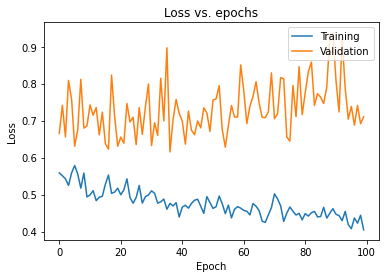

In [139]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- 用简单模型，模型只有轻微过拟合
- 用复杂模型，模型会严重过拟合

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [83]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# 在tensorflow 2.2后的版本， regularizers.l2变成了regularizers.L2

In [99]:

def get_regularised_model(wd=0.01, rate=0.1):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

def get_dropout_model(rate=0.5):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dropout(rate),
        Dense(128, activation="relu"),
        Dropout(rate),
        Dense(1)
    ])

    return model

def get_batch_normalization_model(rate=0.5):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        BatchNormalization(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dense(1)
    ])

    return model

In [100]:
# Re-build the model with weight decay and dropout layers
# model = get_regularised_model(wd=0.005, rate=0.2)
# model = get_dropout_model(rate=0.6)
model = get_batch_normalization_model()

In [101]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

In [102]:
# Train the model, with some of the data reserved for validation


history = model.fit(train_data, train_target, epochs=100, batch_size=32, 
                    validation_split=0.15, verbose=False)

In [103]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target)

2/2 [==============================] - 0s 2ms/step - loss: 0.6745


0.6745143532752991

#### Plot the learning curves

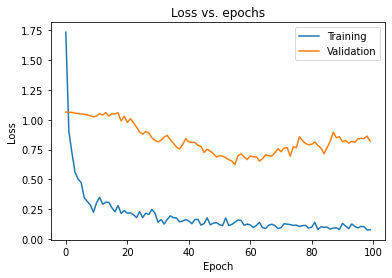

In [104]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [105]:
# Write a custom callback

class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))
       


In [106]:
# Re-build the model

model = get_regularised_model(wd=0.005, rate=0.2)

In [107]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


#### Train the model with the callback

In [108]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=1, batch_size=32, 
                    validation_split=0.15, verbose=False, callbacks=[CustomCallback()])

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['loss', 'mse']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['loss', 'mse']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['loss', 'mse']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['loss', 'mse']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['loss', 'mse']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['loss', 'mse']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['loss', 'mse']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['loss', 'mse']
...Training: start of batch 8; got log keys: []
...Training: end

In [109]:
# Make predictions with the model
predict_results = model.predict(test_data)


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [130]:
# Re-train the unregularised model
model = get_complex_model() 
model.compile(optimizer='adam', loss='mse')
unreg_history = model.fit(train_data, train_target, epochs=100, batch_size=32, 
                    validation_split=0.15, verbose=False, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)])


Epoch 00012: early stopping


In [131]:
# Evaluate the model on the test set

print(model.evaluate(test_data, test_target))



2/2 [==============================] - 0s 1ms/step - loss: 0.5441
0.544099748134613


In [132]:
# Re-train the regularised model

model = get_regularised_model(wd=0.005, rate=0.2)
model.compile(optimizer='adam', loss='mse')
reg_history = model.fit(train_data, train_target, epochs=100, batch_size=32, 
                    validation_split=0.15, verbose=False, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True)])


Epoch 00045: early stopping


In [134]:
# Evaluate the model on the test set

print(model.evaluate(test_data, test_target))


2/2 [==============================] - 0s 1ms/step - loss: 0.6609
0.6608610153198242


#### Plot the learning curves

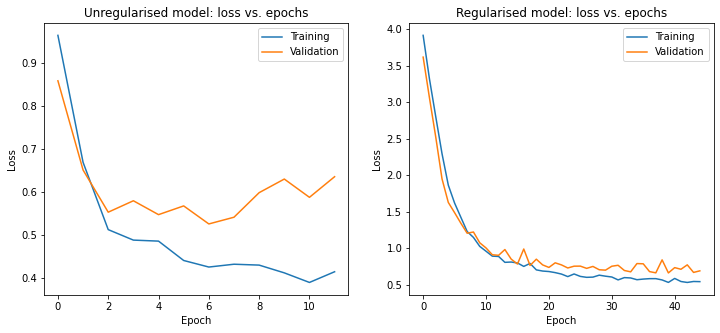

In [135]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()